In [1]:
import numpy as np
import pandas as pd
import datetime
import timeit
import os
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Using TensorFlow backend.


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
def convert_date(str):
    """
    This method is used to convert a string into datetime.
    """
    arr = str.split("-")
    year = int(arr[0])
    month = int(arr[1])

    str = arr[2]
    arr = str.split()
    day = int(arr[0])
    date = datetime.datetime(year = year, month = month, day = day)
    return date

## Get Data

In [4]:
test = pd.read_csv("../input/two-data/test.csv")
data = pd.read_csv("../input/two-data/train.csv")
'''
data = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
display(data.head())
display(test.head())
'''

'\ndata = pd.read_csv("data/train.csv")\ntest = pd.read_csv(\'data/test.csv\')\ndisplay(data.head())\ndisplay(test.head())\n'

## Column selection and categorization

In [5]:
data = data.loc[data['CATERGORY'] == 'Pumpkins']
data

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,0.0,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,0.00000,no ID,Pumpkins
9,4b5e95b3-8a90-4e3a-8bf4-688c47f3b042,3.290,0.0,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:35:25,cash,1.45000,no ID,Pumpkins
132,c787c6a0-6b58-464f-b085-d3165bf95879,3.608,0.9,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-17 11:31:46,cash,19.35540,no ID,Pumpkins
140,a150c94c-d988-4cb1-9b83-45f6d6d154b9,2.346,0.9,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-17 11:38:57,cash,10.41156,no ID,Pumpkins
202,a03ed49b-1609-47b4-ba39-38c1313c0bf8,1.852,2.0,1078,1078.0,Pumpkin Butternut,0.0,1.99,2016-03-17 12:20:52,cash,15.72464,no ID,Pumpkins
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529473,87873c2c-0ad1-40dc-87eb-35f40ac41097,1.050,1.9,1080,1080.0,Pumpkin Grey,0.0,1.99,2018-12-31 09:42:49,cash,7.45072,no ID,Pumpkins
529529,92ad24e6-7d31-4afd-a35b-96b19bd6ca78,1.370,1.9,1080,1080.0,Pumpkin Grey,0.0,1.99,2018-12-31 10:44:00,cash,20.69844,no ID,Pumpkins
529687,5ae24124-3536-40c3-8dea-1ea2cd2625e9,0.978,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2018-12-31 12:48:36,cash,18.90196,no ID,Pumpkins
529826,ec7c744f-72ae-464f-add1-7c7231200cc6,0.780,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2018-12-31 15:15:52,cash,2.74786,no ID,Pumpkins


### Sort by date and assign number to it

In [6]:
date = data['DATENEW'].apply(convert_date)
date

0        2016-03-16
9        2016-03-16
132      2016-03-17
140      2016-03-17
202      2016-03-17
            ...    
529473   2018-12-31
529529   2018-12-31
529687   2018-12-31
529826   2018-12-31
529955   2018-12-31
Name: DATENEW, Length: 11378, dtype: datetime64[ns]

In [7]:
data['DATENEW'] = date
data = data[["DATENEW", "UNITS"]].groupby('DATENEW').sum().reset_index()
data = data.sort_values(by = "DATENEW", ascending = True)
data

,DATENEW,UNITS
0,2016-03-16,6.582
1,2016-03-17,12.104
2,2016-03-18,8.496
3,2016-03-19,9.394
4,2016-03-20,13.858
...,...,...
995,2018-12-24,16.461
996,2018-12-28,7.174
997,2018-12-29,12.692
998,2018-12-30,7.042


## Building Model

In [8]:
test_df = test.loc[test['CATERGORY'] == 'Pumpkins']
test_df

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
3,17079ce3-7a0b-4fbb-a762-977a3ae79667,1.044,2.5,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-01-02 08:34:09,cash,14.49868,no ID,Pumpkins
26,95ab7fce-1164-48a2-8783-0977dfde35ae,0.830,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 09:16:44,cash,8.85466,no ID,Pumpkins
46,1c35de1f-da99-4a7e-83be-c5cbbbb723d7,0.694,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 09:19:19,cash,5.80472,no ID,Pumpkins
115,b418994a-69c6-4d57-b944-07cd16d76370,1.830,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 10:36:07,cash,16.44860,no ID,Pumpkins
147,3ae20864-cf50-42a8-b15e-431c6cd4da03,1.268,2.5,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-01-02 11:02:24,cash,3.15000,no ID,Pumpkins
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129040,e63e7306-912a-4bd7-9100-29a0b9d04533,0.912,2.4,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-10-13 11:31:03,cash,12.09880,no ID,Pumpkins
129138,bc0f97ca-efb5-404a-8927-416aad1976b2,0.806,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 14:12:01,cash,3.64556,no ID,Pumpkins
129188,668fc6a3-40ec-4af7-9188-bf94895675e4,0.992,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 16:01:22,magcard,30.40102,880304475478,Pumpkins
129201,1648444a-ea34-4da5-964e-b31c2922cfe7,1.686,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 16:04:03,cash,12.75100,no ID,Pumpkins


In [9]:
date = test_df['DATENEW'].apply(convert_date)
test_df['DATENEW'] = date
test_df = test_df[["DATENEW", "UNITS"]].groupby('DATENEW').sum().reset_index()
test_df = test_df.sort_values(by = "DATENEW", ascending = True)
test_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DATENEW,UNITS
0,2019-01-02,15.202
1,2019-01-03,10.682
2,2019-01-04,5.164
3,2019-01-05,16.858
4,2019-01-06,8.602
...,...,...
272,2019-10-09,8.900
273,2019-10-10,4.346
274,2019-10-11,8.514
275,2019-10-12,12.140


In [10]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs = nb_epoch, batch_size = batch_size, verbose=0, shuffle = False)
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
sale_series = data['UNITS']
# transform data to be stationary
train_raw_values = sale_series.values
diff_values = difference(train_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
train = supervised.values

sale_series = test_df['UNITS']
# transform data to be stationary
test_raw_values = sale_series.values
diff_values = difference(test_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
test = supervised.values

In [12]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1, 4)
# forecast the entire training dataset to build up state for forecasting
predictions = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(train_raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = train_raw_values[i]
rmse = np.sqrt(mean_squared_error(train_raw_values[:-1], predictions))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 1.023


In [13]:
# cross validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = test_raw_values[i]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=16.172900, Expected=15.202000
Predicted=12.283242, Expected=10.682000
Predicted=7.438475, Expected=5.164000
Predicted=16.807759, Expected=16.858000
Predicted=9.918125, Expected=8.602000
Predicted=13.582321, Expected=13.330000
Predicted=6.955412, Expected=5.434000
Predicted=10.330558, Expected=9.862000
Predicted=6.973126, Expected=5.942000
Predicted=8.693534, Expected=8.260000
Predicted=9.063732, Expected=8.818000
Predicted=8.183062, Expected=7.850000
Predicted=4.933467, Expected=4.050000
Predicted=6.387064, Expected=6.006000
Predicted=2.797896, Expected=1.788000
Predicted=2.853666, Expected=2.096000
Predicted=6.242404, Expected=6.314000
Predicted=16.569152, Expected=18.526000
Predicted=5.474489, Expected=5.024000
Predicted=8.638002, Expected=8.950000
Predicted=5.588713, Expected=5.226000
Predicted=10.726458, Expected=11.424000
Predicted=6.446787, Expected=6.172000
Predicted=8.518791, Expected=8.710000
Predicted=10.870450, Expected=11.464000
Predicted=5.017401, Expected=4.3300

Test RMSE: 1.126


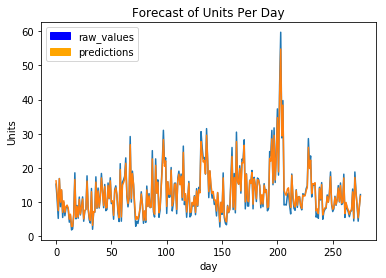

In [14]:
# report performance
rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_raw_values[:-1])
plt.plot(predictions)
blue_patch = mpatches.Patch(color='blue', label='raw_values')
orange_patch = mpatches.Patch(color='orange', label='predictions')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('Units')
plt.xlabel('day')
plt.title('Forecast of Units Per Day')
plt.show()

## Save to csv

In [15]:
'''
pred_df = pd.DataFrame(predictions)
pred_df.index = test_df['DATENEW'][:-1]
pred_df.columns = ['Pumpkins']
pred_df
'''

"\npred_df = pd.DataFrame(predictions)\npred_df.index = test_df['DATENEW'][:-1]\npred_df.columns = ['Pumpkins']\npred_df\n"

In [16]:
'''path = os.path.join('predictions', 'Pumpkins lstm prediction.csv')
pred_df.to_csv(path)
'''

"path = os.path.join('predictions', 'Pumpkins lstm prediction.csv')\npred_df.to_csv(path)\n"

# Find Elbow Point

In [17]:
# fit an LSTM network to training data
batch_size = 1
nb_epoch = 8
result = pd.DataFrame(columns = ['time', 'rmse', 'nb_epoch', 'neurons'])
for neurons in range(1, 101):
    #training part
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    test_code = '''
model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    '''
    time_cost = timeit.timeit(stmt = test_code, setup = 'from __main__ import ' + ', '.join(globals()), number = 1)

    #predicting part
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(model, batch_size, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = test_raw_values[i]
    rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))

    #append to result
    result = result.append(pd.DataFrame({'time': [time_cost], 'rmse': rmse, 'nb_epoch': nb_epoch, 'neurons': neurons}))
result

,time,rmse,nb_epoch,neurons
0,12.721838,5.184845,8,1
0,14.077109,4.738443,8,2
0,14.240398,5.215262,8,3
0,14.008089,5.178429,8,4
0,13.636625,5.156886,8,5
...,...,...,...,...
0,15.835210,4.956335,8,96
0,16.171276,4.937922,8,97
0,16.834327,4.942553,8,98
0,16.240144,4.973532,8,99


Text(0.5, 1.0, 'Time vs RMSE')

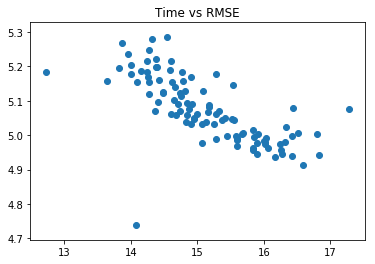

In [18]:
plt.scatter(result['time'], result['rmse'])
plt.title('Time vs RMSE')